In [183]:
%config Completer.use_jedi = False
import os
import glob
import pandas as pd
import numpy as np
import sklearn
import torch
import transformers
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,AutoModel
device = torch.device("cuda")


In [96]:
import re

In [24]:
os.chdir("./Dataset/youtube_spam/")

In [35]:
# extension = 'csv'
# all_filenames = glob.glob('*.{}'.format(extension))
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
# combined_csv.to_csv( "youtube_spam_detection.csv", index=False)

In [237]:
df=pd.read_csv('./youtube_spam_detection.csv') 

In [238]:
df['CONTENT'] = df['CONTENT'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE) ### remove \ufeff,emoji and other punctuations

In [239]:
df['CONTENT']

0       Huh, anyway check out this youtube channel: ko...
1       Hey guys check out my new channel and our firs...
2                  just for test I have to say murdev.com
3           me shaking my sexy ass on my channel enjoy _ 
4                    watchvvtaRGgvGtWQ   Check this out .
                              ...                        
1951    I love this song because we sing it at Camp al...
1952    I love this song for two reasons: 1.it is abou...
1953                                                  wow
1954                              Shakira u are so wiredo
1955                           Shakira is the best dancer
Name: CONTENT, Length: 1956, dtype: object

In [240]:
train_text, test_text,train_labels,test_labels=train_test_split(df['CONTENT'],df['CLASS'])


<AxesSubplot:>

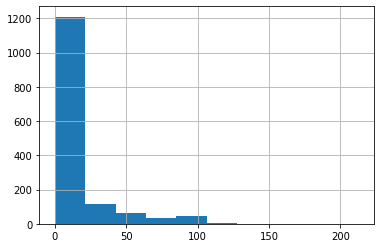

In [241]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist()

In [242]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

In [243]:
# sent_id=tokenizer.batch_encode_plus(df['CONTENT'])
# sent_id['input_ids']

In [132]:
# train_text.tolist()
# tokenizer.batch_encode_plus()

In [244]:
train_tokens=tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True)
test_tokens=tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True)

In [245]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [246]:
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### DataLoader

#### https://www.youtube.com/watch?v=zN49HdDxHi8
###### Manage dataset 
##### batches of data
##### Iterations
1000 data 2 batch 2 iterations 


In [247]:
train_data=TensorDataset(train_seq,train_mask,train_y)
train_data

In [248]:
train_sampler = RandomSampler(train_data)
batch_size = 2
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [249]:
class BERT_Arch(nn.Module):
    

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
        x = self.fc1(cls_hs)
        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [250]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [251]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [252]:
from sklearn.utils.class_weight import compute_class_weight

In [253]:
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.04190341 0.96133683]


C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=850     0
939     1
711     0
908     1
472     1
       ..
47      1
306     0
1814    0
1277    0
1087    1
Name: CLASS, Length: 1467, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [254]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [256]:
for step,batch in enumerate(train_dataloader):
    print(step,batch)

0 [tensor([[  101,  2066,  4402,  4402,  4402,  4402,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2064,  1045,  2131,  5328,  1998, 17073,  2005,  2053,  3114,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), tensor([0, 1])]
1 [tensor([[  101,  8840,  2140,  1045,  2293,  2023,  2299,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2003,  2008, 12756,  4419,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,    

157 [tensor([[ 101, 3835, 2000, 3113, 2017, 1011, 2023, 2003, 5206, 1024, 1015, 1012,
         2065, 2017, 2525, 2113, 2026, 2189, 1011, 7639, 2023, 2039, 1010, 2138,
          102],
        [ 101, 1996, 2329, 2015, 2170, 2008, 4715, 2021, 2017, 2113, 1996, 2995,
         2773, 2003, 2374, 1998, 1996, 2149, 3329, 2003, 2170, 4043, 1012, 2008,
          102]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), tensor([1, 1])]
158 [tensor([[ 101, 4638, 2041, 2023, 2678, 2006, 7858, 1024,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 4638, 2041, 2023, 2678, 2006, 7858, 1024,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

330 [tensor([[ 101, 3013, 2666, 2611, 1998, 3376, 2299,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 4638, 2041, 2026, 7858, 3149, 1045, 2064, 9680,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), tensor([0, 1])]
331 [tensor([[  101, 23046,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 22512,  4942, 29234,  2026,  3149,  2208, 13213, 20492,  2050,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), tensor([[1, 1, 1, 

516 [tensor([[  101,  2023,  2299,  2003,  2307,  2045,  2024,  1016,  1010, 13029,
          1010, 22904,  1010, 20317,  5328, 10166,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2490,  1996,  2954,  2005,  2115,  4343,  7450,  2157,  2000,
          9394,  1999,  2115,  2188,  1012,  2644,  1996, 23971, 22624,  2006,
          4841,  2007,  1996,  4895,   102]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), tensor([0, 1])]
517 [tensor([[  101,  4942, 29234,  2000,  2026,  3149,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  2293, 25439,  2013,  6504,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

699 [tensor([[ 101, 2200, 2204, 2066, 1024, 1040,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 2145, 5962, 1999, 2325,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), tensor([0, 0])]
700 [tensor([[  101,  4942,  1018,  4942,  3531,  2066,  2023,  7615,  1045,  2215,
          1037, 10514,  9468,  2229,  3993,  2140,  7858,  2061,  4903, 19738,
          3366,  2066,  2023,  7615,   102],
        [  101,  1059, 24475,  1012,  4942, 29234,  2026,  3149,  2084,  2595,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), tensor([[1, 1, 1, 

In [232]:
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        print(step,batch)
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [233]:
def evaluate():
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
        # model predictions
        preds = model(sent_id, mask)

        # compute the validation loss between actual and predicted values
        loss = cross_entropy(preds,labels)

        total_loss = total_loss + loss.item()
        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [234]:
torch.cuda.empty_cache()

In [235]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
0 [tensor([[  101,  4638,  2041,  2023,  2678,  2006,  7858,  1024, 29017,  2072,
          4213,  3501, 26291, 22734,  3501,  4160,  3900, 12083, 22287,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     

AttributeError: 'str' object has no attribute 'dim'